# STATS

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import wrangle

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.sentiment

In [21]:
train, val, test = wrangle.wrangle_glassdoor()
three_star = train[train.binned_rating_int == 3]
four_star = train[train.binned_rating_int == 4]

In [6]:
four_star.head()

,pros,cons,name,rating,ceo_approval,friend_recommendation,pros_cleaned,pros_lemmatized,cons_cleaned,cons_lemmatized,binned_rating,binned_rating_int
url,,,,,,,,,,,,
https://www.glassdoor.com/Reviews/Perficient-Reviews-E9329.htm,Perficient is an ethical company that actually...,"None at all, love, love, love this company!\nI...",Perficient,4.1,87.0,80.0,perficient is an ethical company that actually...,perficient ethical company actually value empl...,none at all love love love this company\nit is...,none love love love company good company canno...,Four,4
https://www.glassdoor.com/Reviews/MIT-Reviews-E2889.htm,"Very inspiring place to work at, to feel that ...",Depends on the project to how much organizatio...,MIT,4.4,90.0,86.0,very inspiring place to work at to feel that s...,inspiring place work feel something new happen...,depends on the project to how much organizatio...,depends project much organization team include...,Four,4
https://www.glassdoor.com/Reviews/Morningstar-Reviews-E3299.htm,"- Coworkers are amicable, and they're overall ...",- Base pay for the area could be slightly high...,Morningstar,4.1,94.0,86.0,coworkers are amicable and they ' re overall v...,coworkers amicable ' overall supportive unlimi...,base pay for the area could be slightly higher...,base pay area could slightly higher bonus prog...,Four,4
https://www.glassdoor.com/Reviews/L-Or%C3%A9al-Reviews-E3470.htm,Good pay and benefits. Paid time off. Work lif...,No cons at the moment\nonly Location could be ...,L'Oréal,4.0,92.0,79.0,good pay and benefits paid time off work life ...,good pay benefit paid time work life balance c...,no cons at the moment\nonly location could be ...,con moment location could better politics stre...,Four,4
https://www.glassdoor.com/Reviews/Novartis-Reviews-E6667.htm,"Strong rewards and incentives: salary, bonus, ...","Leadership says one thing (e.g., be unbossed) ...",Novartis,4.0,81.0,78.0,strong rewards and incentives salary bonus sto...,strong reward incentive salary bonus stock hea...,leadership says one thing eg be unbossed but c...,leadership say one thing eg unbossed consisten...,Four,4


# Significance of words (tf-idf)

The IDF (Inverse Document Frequency) score is calculated to measure the importance of a word within a collection of documents. The IDF score indicates how rare or common a word is across the entire corpus.

- A higher IDF score suggests that a word is more unique and significant within the collection of documents.

In [7]:
def generate_trigrams(lemmatized):
    words = lemmatized.split()
    trigrams = []
    
    if len(words) < 3:
        return trigrams

    for i in range(len(words) - 1):
        if len(words[i]) > 1 and len(words[i+1]) > 1:
            trigram = " ".join(words[i:i+3])
            trigrams.append(trigram)

    return trigrams

**Calculate the TF score**

In [8]:
documents = {
    'pros': " ".join(four_star.pros_lemmatized.values),
    'cons': " ".join(four_star.cons_lemmatized.values),
}

# Create an empty list to store the TF dataframes
tfs = []

# Iterate through documents and their corresponding text
for doc, text in documents.items():
    # Split the text into words, count their occurrences, and reset the index
    word_counts = pd.Series(generate_trigrams(text)).value_counts()

    # Rename the columns for clarity and calculate the term frequency (TF)
    tf_df = pd.DataFrame(word_counts).reset_index()
    tf_df.columns = ['word', 'count']
    tf_df["tf"] = tf_df['count'] / len(generate_trigrams(text))
    tf_df = tf_df.assign(doc = doc)

    # Append the TF dataframe to the list
    tfs.append(tf_df)

In [9]:
tfs[1]

,word,count,tf,doc
0,work life balance,317,0.001410,cons
1,none none none,101,0.000449,cons
2,pay could better,72,0.000320,cons
3,great place work,61,0.000271,cons
4,get thing done,48,0.000213,cons
...,...,...,...,...
184102,make sure company,1,0.000004,cons
184103,sure company applying,1,0.000004,cons
184104,company applying within,1,0.000004,cons
184105,applying within cox,1,0.000004,cons


**Calculate IDF score**

In [10]:
def idf(word):
    """
    calculates the Inverse Document Frequency (IDF) for a given word in a collection of documents.
    """
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / (n_occurences + 1)

In [11]:
# Calculate the if-idf score of each word and add to the if dataframe
tf_idf_scores = pd.concat(tfs, axis=0).assign(idf=lambda df: df.word.apply(idf)).assign(tf_idf=lambda df: df.idf * df.tf)

In [12]:
tf_idf_scores.head()

,word,count,tf,doc,idf,tf_idf
0,work life balance,1066,0.005938,pros,0.666667,0.003958
1,great place work,287,0.001599,pros,0.666667,0.001066
2,good work life,284,0.001582,pros,0.666667,0.001055
3,great company work,165,0.000919,pros,0.666667,0.000613
4,great work life,153,0.000852,pros,0.666667,0.000568


**Add sentiment scores for each word**

In [13]:
# use polarity_scores from that object
sia = nltk.sentiment.SentimentIntensityAnalyzer()
# grab the sentiment from each of the texts as they stand
tf_idf_scores['sentiment'] = tf_idf_scores.word.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [14]:
tf_idf_scores.head()

,word,count,tf,doc,idf,tf_idf,sentiment
0,work life balance,1066,0.005938,pros,0.666667,0.003958,0.0000
1,great place work,287,0.001599,pros,0.666667,0.001066,0.6249
2,good work life,284,0.001582,pros,0.666667,0.001055,0.4404
3,great company work,165,0.000919,pros,0.666667,0.000613,0.6249
4,great work life,153,0.000852,pros,0.666667,0.000568,0.6249


**Add to csv**

In [15]:
# tf_idf_scores.to_csv("./data/three_star_tf_idf_scores.csv", mode="w")

In [16]:
# tf_idf_scores.to_csv("./data/four_star_tf_idf_scores.csv", mode="w")

### Test documents together

In [22]:
train = train.copy()
three_star = pd.read_csv("./data/three_star_tf_idf_scores.csv", index_col=0)
four_star = pd.read_csv("./data/four_star_tf_idf_scores.csv", index_col= 0)
three_star.head(2)

,word,count,tf,doc,idf,tf_idf,sentiment
0,work life balance,1320,0.003417,pros,0.666667,0.002278,0.0000
1,great place work,495,0.001281,pros,0.666667,0.000854,0.6249


In [23]:
train.head(2)

,pros,cons,name,rating,ceo_approval,friend_recommendation,pros_cleaned,pros_lemmatized,cons_cleaned,cons_lemmatized,binned_rating,binned_rating_int
url,,,,,,,,,,,,
https://www.glassdoor.com/Reviews/Perficient-Reviews-E9329.htm,Perficient is an ethical company that actually...,"None at all, love, love, love this company!\nI...",Perficient,4.1,87.0,80.0,perficient is an ethical company that actually...,perficient ethical company actually value empl...,none at all love love love this company\nit is...,none love love love company good company canno...,Four,4
https://www.glassdoor.com/Reviews/Farmers-Insurance-Group-Reviews-E3955.htm,"This company is the best ever.\nLarge, establi...",I have nothing bad to say.\nManagement company...,Farmers Insurance Group,3.4,37.0,52.0,this company is the best ever\nlarge establish...,company best ever large established company so...,i have nothing bad to say\nmanagement company ...,nothing bad say management company get paid re...,Three,3


In [24]:
def Hypothesis_check(p_value, alpha = 0.05):
    if p_value < alpha:
        print("Reject null")
    else:
        print("Fail to reject null")

1. **Does word count affect sentiment?**
   - Null Hypothesis (H0): There is no significant relationship between word count and sentiment.
   - Alternative Hypothesis (H1): There is a significant relationship between word count and sentiment.

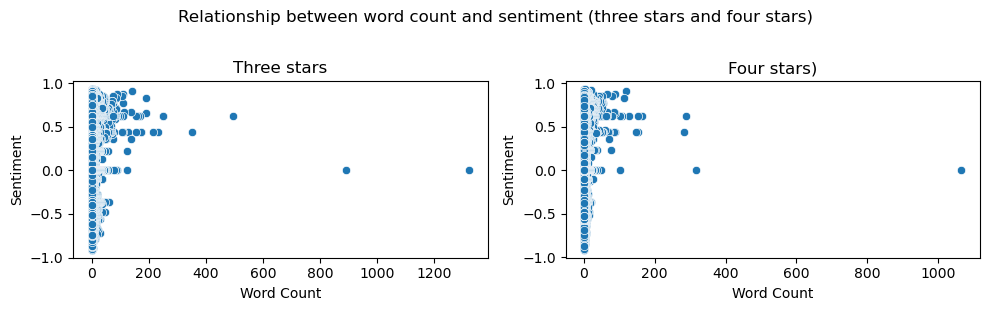

In [29]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.scatterplot(data=three_star, x="count", y="sentiment", ax=axs[0])
axs[0].set_title("Three stars")
axs[0].set_xlabel("Word Count")
axs[0].set_ylabel("Sentiment")

# Plot the second scatterplot on the second subplot and set title and labels
sns.scatterplot(data=four_star, x="count", y="sentiment", ax=axs[1])
axs[1].set_title("Four stars)")
axs[1].set_xlabel("Word Count")
axs[1].set_ylabel("Sentiment")

# Add a main title for the entire figure
plt.suptitle("Relationship between word count and sentiment (three stars and four stars)", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Three star rating**

In [37]:
statistic, p_value = stats.spearmanr(three_star["count"],three_star.sentiment)
Hypothesis_check(p_value)
print("r_coeficient:",statistic)

Reject null
r_coeficient: 0.025026960076629315


**Four star rating**

In [38]:
statistic, p_value = stats.spearmanr(four_star["count"],four_star.sentiment)
Hypothesis_check(p_value)
print("r_coeficient:",statistic)

Reject null
r_coeficient: 0.03173805496766481


2. **Is there a correlation between word frequency (tf) and sentiment?**
   - H0: There is no significant correlation between word frequency (tf) and sentiment.
   - H1: There is a significant correlation between word frequency (tf) and sentiment.

3. **Does the inverse document frequency (idf) of a word impact its sentiment?**
   - H0: There is no significant impact of inverse document frequency (idf) on sentiment.
   - H1: There is a significant impact of inverse document frequency (idf) on sentiment.

4. **Do words with higher tf-idf scores tend to have a specific sentiment?**
   - H0: There is no significant relationship between tf-idf scores and sentiment.
   - H1: There is a significant relationship between tf-idf scores and sentiment.

5. **Is there a significant difference in sentiment between different documents (doc) or groups of documents?**
   - H0: There is no significant difference in sentiment between documents or groups of documents.
   - H1: There is a significant difference in sentiment between documents or groups of documents.

6. **Do specific words have significantly different sentiment scores compared to the overall sentiment of the documents they appear in?**
   - H0: The sentiment of specific words is not significantly different from the overall sentiment of the documents they appear in.
   - H1: The sentiment of specific words is significantly different from the overall sentiment of the documents they appear in.

7. **Is there a significant difference in sentiment scores across different word categories or topics?**
   - H0: There is no significant difference in sentiment scores across word categories or topics.
   - H1: There is a significant difference in sentiment scores across word categories or topics.

8. **Does the sentiment of a document correlate with its length (word count)?**
   - H0: There is no significant correlation between document length and sentiment.
   - H1: There is a significant correlation between document length and sentiment.

9. **Is there a significant difference in sentiment scores across different documents (doc)?**
   - H0: There is no significant difference in sentiment scores across different documents.
   - H1: There is a significant difference in sentiment scores across different documents.

10. **Does sentiment vary significantly between documents with different levels of word frequency (tf)?**
    - H0: There is no significant difference in sentiment between documents with different levels of word frequency (tf).
    - H1: There is a significant difference in sentiment between documents with different levels of word frequency (tf).

### Test documents seperatly

1. **Is there a significant difference in sentiment between the two documents?**
   - H0: There is no significant difference in sentiment between the two documents.
   - H1: There is a significant difference in sentiment between the two documents.

2. **Do specific words have significantly different sentiment scores between the two documents?**
   - H0: The sentiment of specific words is not significantly different between the two documents.
   - H1: The sentiment of specific words is significantly different between the two documents.

3. **Is there a significant correlation between word frequency (tf) and sentiment within each document?**
   - For Document 1:
     - H0: There is no significant correlation between word frequency (tf) and sentiment within Document 1.
     - H1: There is a significant correlation between word frequency (tf) and sentiment within Document 1.

   - For Document 2:
     - H0: There is no significant correlation between word frequency (tf) and sentiment within Document 2.
     - H1: There is a significant correlation between word frequency (tf) and sentiment within Document 2.

4. **Is there a significant difference in sentiment scores between words in Document 1 and words in Document 2?**
   - H0: There is no significant difference in sentiment scores between words in Document 1 and words in Document 2.
   - H1: There is a significant difference in sentiment scores between words in Document 1 and words in Document 2.

5. **Does the sentiment of each document correlate with its respective word count?**
   - For Document 1:
     - H0: There is no significant correlation between the word count of Document 1 and its sentiment.
     - H1: There is a significant correlation between the word count of Document 1 and its sentiment.

   - For Document 2:
     - H0: There is no significant correlation between the word count of Document 2 and its sentiment.
     - H1: There is a significant correlation between the word count of Document 2 and its sentiment.

6. **Is there a significant difference in sentiment scores between the two documents based on their word count?**
   - H0: There is no significant difference in sentiment scores between the two documents based on their word count.
   - H1: There is a significant difference in sentiment scores between the two documents based on their word count.

7. **Do specific words have significantly different sentiment scores between Document 1 and Document 2 based on their tf-idf scores within each document?**
   - H0: The sentiment of specific words is not significantly different between Document 1 and Document 2 based on their tf-idf scores.
   - H1: The sentiment of specific words is significantly different between Document 1 and Document 2 based on their tf-idf scores.